In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                full_dataset.append((aptamer, peptide))
    full_dataset = list(set(full_dataset)) #removed duplicates
    return full_dataset

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, training_set):
        super(TrainDataset, self).__init__() 
        self.training_set = training_set
        
    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.training_set[idx]
        return aptamer, peptide
    

aptamer_dataset_file = "../data/aptamer_dataset.json"
full_dataset = construct_dataset()
n = len(full_dataset)
training_set = full_dataset[:int(0.8*n)]
test_set = full_dataset[int(0.8*n):]
train_dataset = TrainDataset(training_set)
train_loader = torch.utils.data.DataLoader(train_dataset)

## NN Model

In [4]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

## Sampling methods

In [5]:
# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S' contains S with double the size of S (domain for Importance Sampling)
def get_S_prime(k):
    S_prime_dict = dict.fromkeys(training_set, 0) #indicator 0 means in the original dataset
    S_new = []
    for _ in range(k):
    
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in the original dataset
        S_new.append(pair)
    while len(S_new) < 10 * k:
        pair = (get_x(), get_y())
        S_new.append(pair)
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()]
    random.shuffle(S_prime)
    return S_prime, S_new

# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf


S_prime, S_new = get_S_prime(n) #use for sgd and eval

## Helper methods

In [6]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    pmf = get_y_pmf(y)
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return pmf, out

def get_log_out(k):
    outs = []
    for (apt, pep) in training_set[:k]:
        x, y = convert(apt, pep)
        _, out = update(x, y)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_log_out_test(k):
    outs = []
    for (apt, pep) in test_set[:k]:
        x, y = convert(apt, pep)
        _, out = update(x, y)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(k):
    outs = []
    for (apt, pep) in S_new[:k]:
        x, y = convert(apt, pep)
        _, out = update(x, y)
        outs.append(out.cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# AUC Plot
def cdf(scores1, scores2, i): # i is the index
    _, ax = plt.subplots()
    ax.hist(scores1, 100, histtype='step', density=True, cumulative=True, color='red', label='train cdf')
    ax.hist(scores2, 100, histtype='step', density=True, cumulative=True, color='black', label='test cdf')
    ax.legend()
    plt.show()

## SGD

In [7]:
def sgd(t=1, #num of iter over the training set
        lamb=1e-1, #hyperparam
        gamma=1e-2): #step size
    train_correct = 0
    test_correct = 0
    optim = SGD(model.parameters(), lr=gamma)
    for _ in range(t):
        for i, (apt, pep) in enumerate(tqdm.tqdm(train_loader)):
            if i == 0:
                continue
            model.train()
            
            optim.zero_grad() #reset gradients after update
            
            x, y = convert(apt[0], pep[0]) #sample x,y from training set S
            _, out = update(x, y) #get train score
            log_out = torch.log(out) #take log
            
            train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
            if train_score > 0.75:
                train_correct += 1 #contribute to train recall
            train_recall_outputs.append(train_score) #store the train scores
            
            optim.zero_grad() #reset gradients for the second branch
            
            x_prime, y_prime = convert(S_prime[i][0][0], S_prime[i][0][1]) #sample x', y' from S'
            y_pmf, out_prime = update(x_prime, y_prime) #get score'
            out_prime = out_prime*y_pmf*get_x_pmf()*2*n #adjust for IS
            
            const = S_prime[i][1] #indicator
            (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
            optim.step() #gradient update
                
            if i < int(0.2*n): #check if idx out of range
                model.eval()
                x_test, y_test = convert(test_set[i][0], test_set[i][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
                test_recall_outputs.append(test_score) #store the test scores
                if test_score > 0.75:
                    test_correct += 1 #contribute to test recall
            #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
            for x, y in S_new[-(10*i+1):9-10*i]:
                x_eval, y_eval = convert(x, y) #generate unseen x'' and y''
                score_eval = model(x_eval, y_eval).cpu().detach().numpy().flatten()[0] #get unknown score
                eval_unknown_outputs.append(score_eval) #store the unknown scores

            if i % 50 == 0:
                train_loss = lamb*get_out_prime(1000) - get_log_out(1000) #training loss
                test_loss = lamb*get_out_prime(1000) - get_log_out_test(1000) #test loss
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                
                train_score = np.asarray(eval_unknown_outputs + train_recall_outputs) #combine train and unknown scores
                test_score = np.asarray(eval_unknown_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.sum(np.cumsum(train_score), dtype=float)/(np.sum(train_score)*len(train_score)) #train cdf
                test_cdf = np.sum(np.cumsum(test_score), dtype=float)/(np.sum(test_score)*len(test_score)) #test cdf
                train_cdfs.append(train_cdf)
                test_cdfs.append(test_cdf)
            if i % 10000 == 0:
                _, ax = plt.subplots()
                T = [i for i in range(51, i, 10000//50)]
                ax.plot(train_losses, 'g', label='Train loss')
                ax.plot(test_losses, 'p', label='Test loss')
                ax.plot(train_recalls, 'b', label='Train recall')
                ax.plot(test_recalls, 'y', label='Test recall')
                ax.legend()
                g = gammas[j//len(lambdas)]
                l = lambdas[j%len(lambdas)]
                ax.set_title('lambda =%.5f' % l  + ' gamma =%.5f' % g)
                plt.show()
                print("Train cdfs: ", train_cdfs[-2])
                print("Test cdfs: ", test_cdfs[-2])
                print("Train scores unkown: ", train_score[:2])
                print("Train scores train: ", train_score[-2:])
                print("Test scores unkown: ", test_score[:2])
                print("Test scores train: ", test_score[-2:])
                cdf(train_score, test_score, j)

## Hyperparameter tuning

In [8]:
gammas = [1e-2]
lambdas = [1e-1, 1e-3, 10, 100, 1e-5]
j = 0

  2%|▏         | 9999/473047 [22:37<5:17:13, 24.33it/s] 

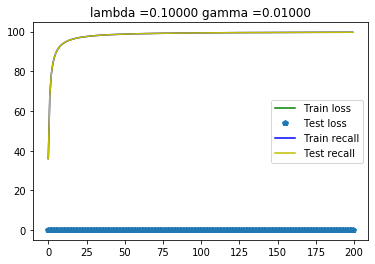

Train cdfs:  0.4990940266516935
Test cdfs:  0.4990915328570512
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99993014 0.99992335]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999342 0.9999279]


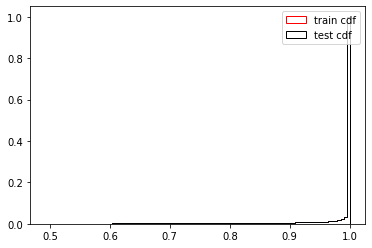

  4%|▍         | 19995/473047 [45:42<6:20:09, 19.86it/s] 

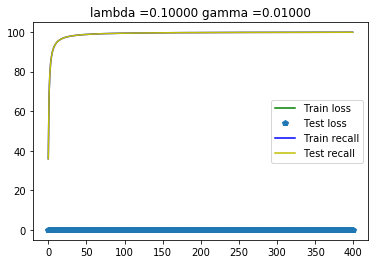

Train cdfs:  0.49955578972877246
Test cdfs:  0.4995545008646345
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99996614 0.99996555]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999627 0.9999664]


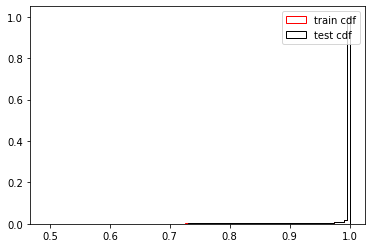

  6%|▋         | 29997/473047 [1:09:25<4:24:59, 27.87it/s] 

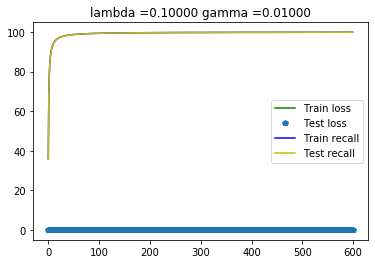

Train cdfs:  0.49970773152858466
Test cdfs:  0.49970686874271836
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999814 0.9999777]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99997854 0.99998236]


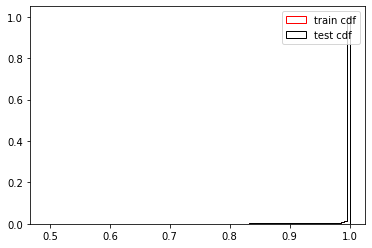

  8%|▊         | 39999/473047 [1:33:47<4:36:08, 26.14it/s] 

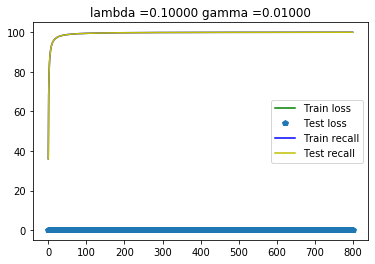

Train cdfs:  0.499782789300177
Test cdfs:  0.49978214256244186
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99998367 0.9999858 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999821 0.9999832]


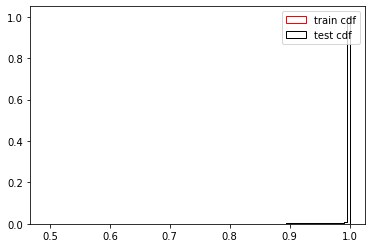

 11%|█         | 49997/473047 [2:06:55<4:05:51, 28.68it/s]  

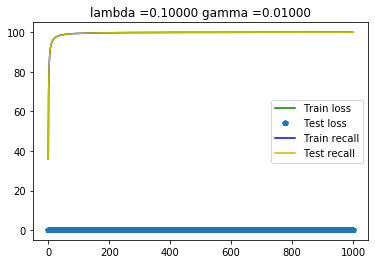

Train cdfs:  0.499827479631687
Test cdfs:  0.49982690810400066
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999896 0.999987 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99998987 0.999987  ]


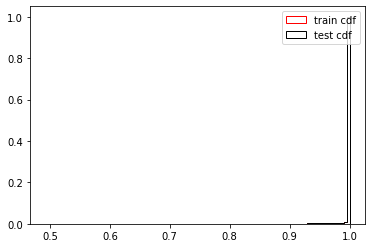

 13%|█▎        | 59985/473047 [2:30:59<10:47:16, 10.64it/s]

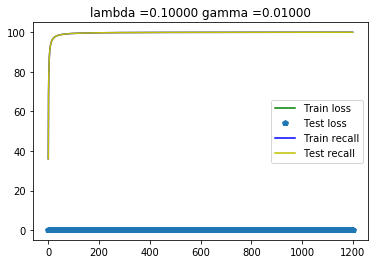

Train cdfs:  0.4998553007020998
Test cdfs:  0.4998548258052627
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999912  0.99999046]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999154 0.9999895 ]


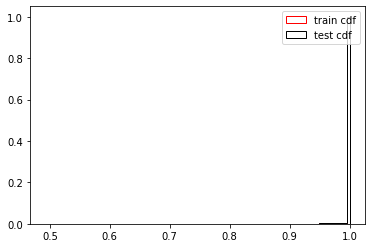

 15%|█▍        | 70000/473047 [2:52:16<8:18:23, 13.48it/s] 

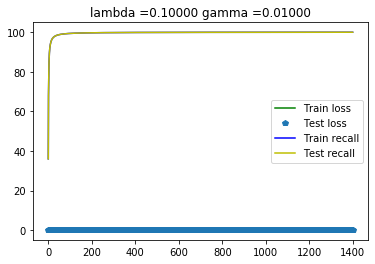

Train cdfs:  0.49985710976693026
Test cdfs:  0.49985664984342953
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999906 0.9999914]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999225 0.9999924 ]


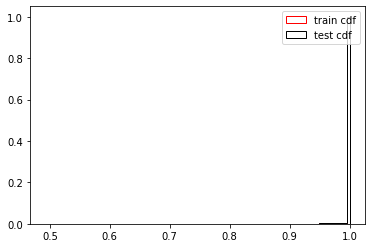

 17%|█▋        | 79995/473047 [3:13:56<9:59:23, 10.93it/s] 

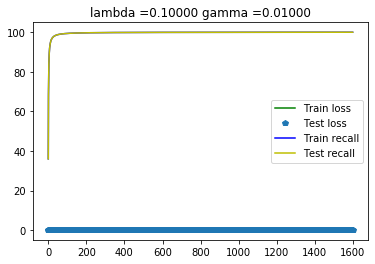

Train cdfs:  0.49985887745279345
Test cdfs:  0.499858431827698
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999404 0.99999404]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999356 0.99999356]


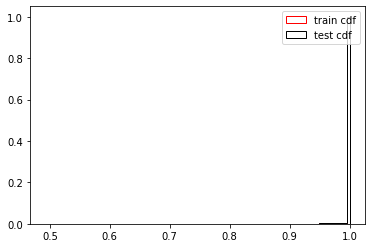

 19%|█▉        | 89985/473047 [3:35:08<9:32:53, 11.14it/s] 

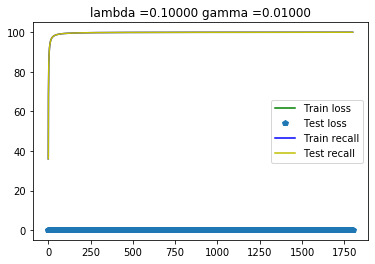

Train cdfs:  0.4998606050383112
Test cdfs:  0.4998601730763439
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999356 0.99999297]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999404 0.99999404]


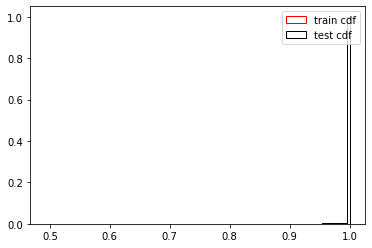

 21%|██        | 99995/473047 [4:05:00<8:39:16, 11.97it/s]  

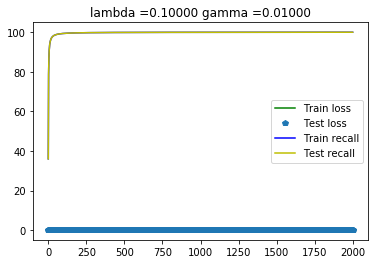

Train cdfs:  0.4998622937591283
Test cdfs:  0.4998618748618045
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999938 0.9999951]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999938 0.9999937]


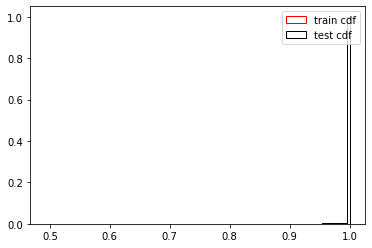

 23%|██▎       | 109984/473047 [4:27:50<8:56:13, 11.28it/s] 

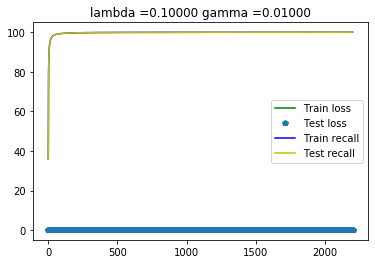

Train cdfs:  0.4998639448087959
Test cdfs:  0.4998635384118063
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999933  0.99999464]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999595 0.99999404]


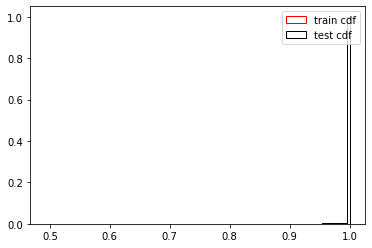

 25%|██▌       | 119984/473047 [4:49:33<8:42:43, 11.26it/s] 

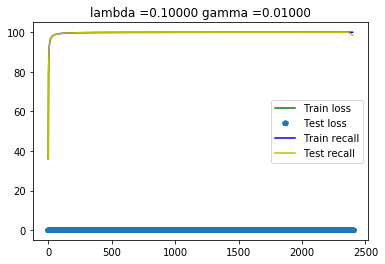

Train cdfs:  0.49986555933976273
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999957 0.9999951]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


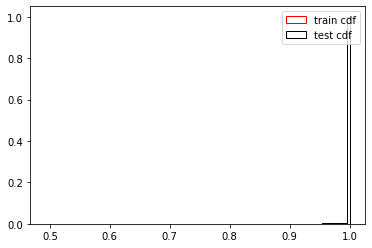

 27%|██▋       | 129995/473047 [5:10:53<9:55:17,  9.60it/s] 

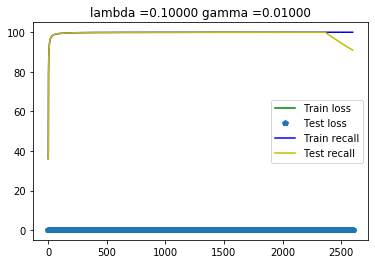

Train cdfs:  0.499867181797836
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999666 0.9999958 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


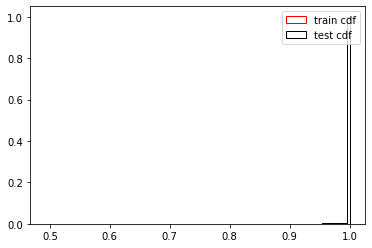

 30%|██▉       | 140000/473047 [5:32:31<6:28:01, 14.30it/s] 

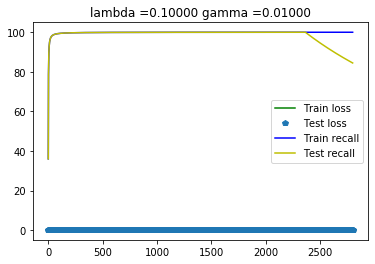

Train cdfs:  0.49986872599704973
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999962  0.99999714]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


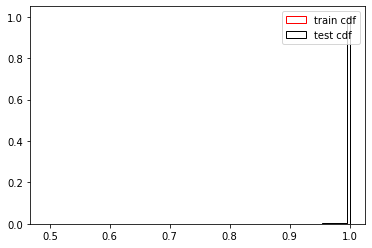

 32%|███▏      | 149992/473047 [5:58:03<13:37:49,  6.58it/s]

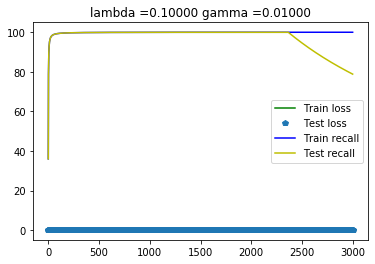

Train cdfs:  0.49987019475124506
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999968  0.99999607]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


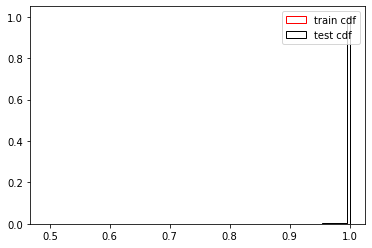

 34%|███▍      | 159988/473047 [6:23:59<11:24:12,  7.63it/s]

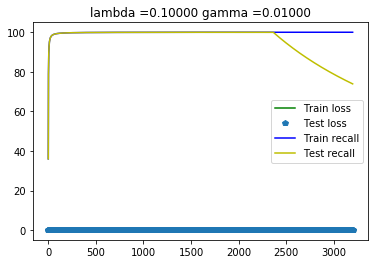

Train cdfs:  0.49987163234568294
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999714 0.9999968 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


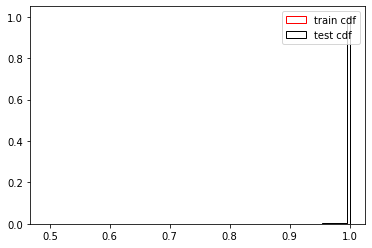

 36%|███▌      | 169978/473047 [6:45:29<12:28:06,  6.75it/s]

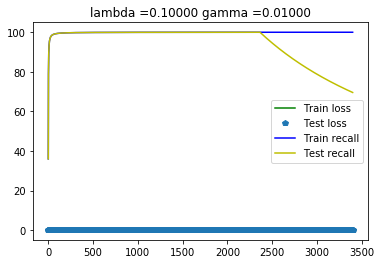

Train cdfs:  0.4998730396993521
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999714 0.99999714]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


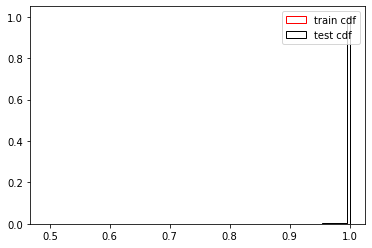

 38%|███▊      | 179989/473047 [7:06:53<8:11:04,  9.95it/s] 

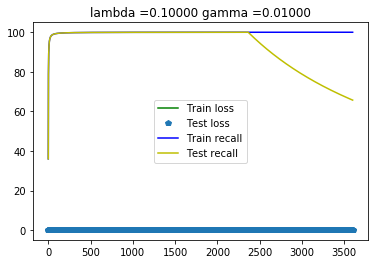

Train cdfs:  0.49987441769940205
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999969 0.999997 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


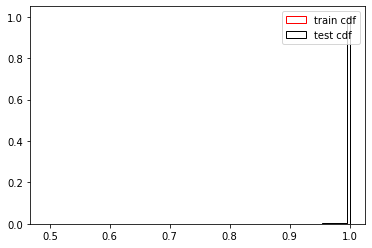

 40%|████      | 189988/473047 [7:28:02<9:42:54,  8.09it/s] 

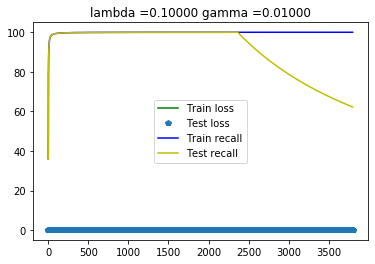

Train cdfs:  0.4998757672021806
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999976 0.9999975]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


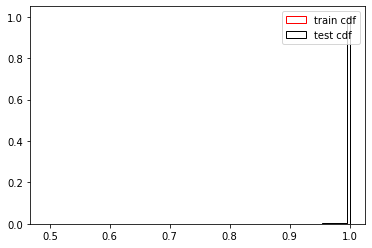

 42%|████▏     | 199980/473047 [7:49:08<9:39:56,  7.85it/s] 

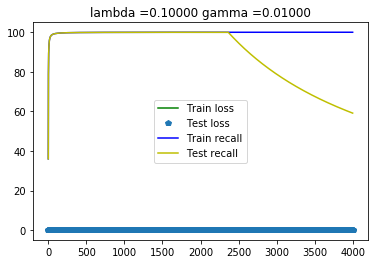

Train cdfs:  0.4998770890342676
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.999998  0.9999976]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


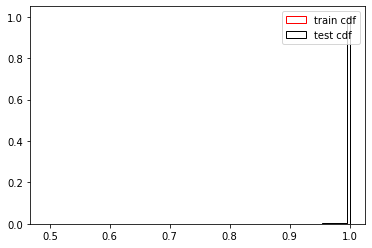

 44%|████▍     | 209992/473047 [8:18:53<8:54:38,  8.20it/s] 

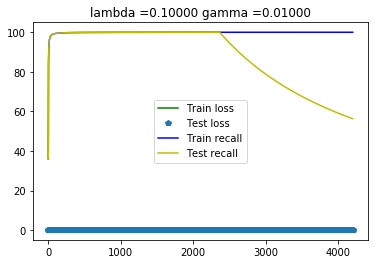

Train cdfs:  0.49987838399349915
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999974 0.9999981]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


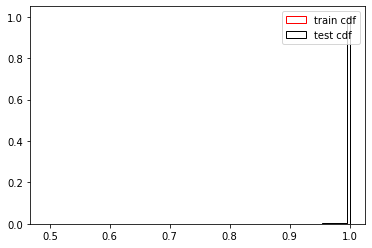

 47%|████▋     | 219999/473047 [8:39:40<6:32:09, 10.75it/s] 

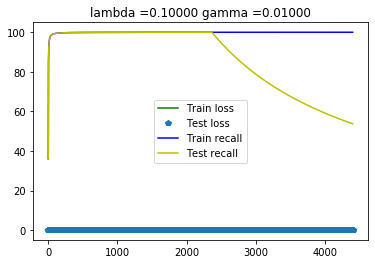

Train cdfs:  0.49987965284997676
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999974 0.9999981]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


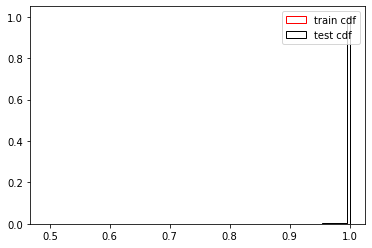

 49%|████▊     | 229979/473047 [9:00:40<9:34:58,  7.05it/s] 

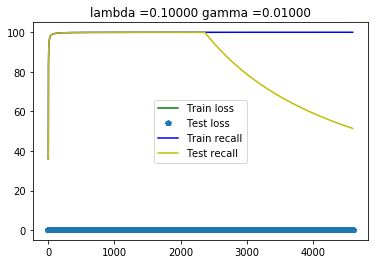

Train cdfs:  0.4998808963470575
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999981  0.99999845]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


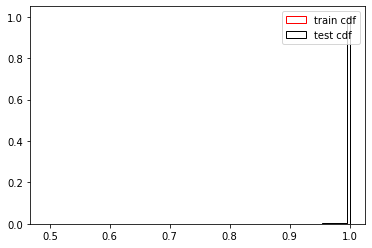

 51%|█████     | 239980/473047 [9:21:29<9:13:20,  7.02it/s] 

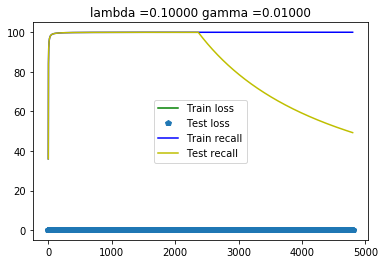

Train cdfs:  0.49988211520232295
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999774 0.99999857]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


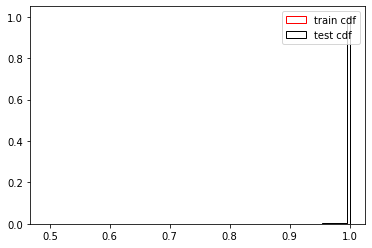

 53%|█████▎    | 249980/473047 [9:42:30<8:36:36,  7.20it/s] 

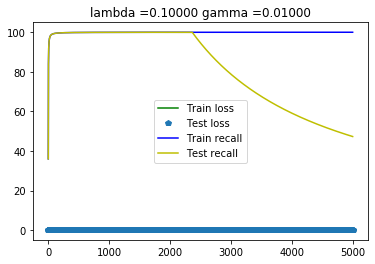

Train cdfs:  0.49988331010852405
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999982  0.99999785]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


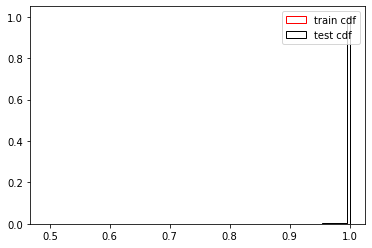

 55%|█████▍    | 259991/473047 [10:12:16<8:37:38,  6.86it/s]  

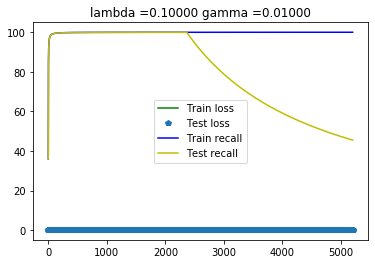

Train cdfs:  0.49988448173450006
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999857 0.999998  ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


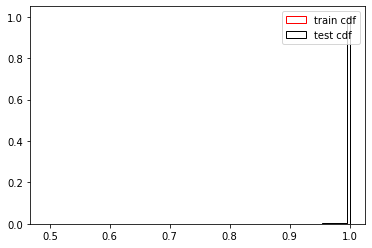

 57%|█████▋    | 269996/473047 [10:34:07<5:08:19, 10.98it/s] 

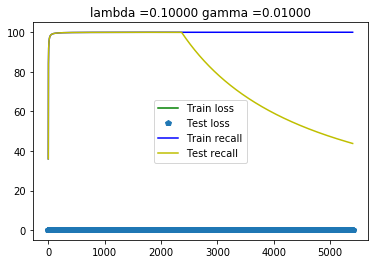

Train cdfs:  0.4998856307260709
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999785 0.999998  ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


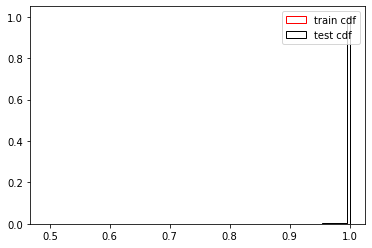

 59%|█████▉    | 279989/473047 [10:55:33<6:31:36,  8.22it/s] 

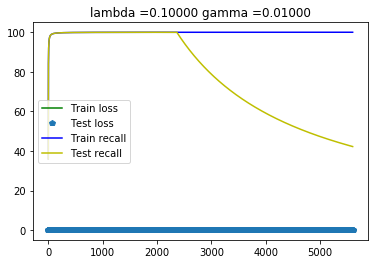

Train cdfs:  0.49988675770690155
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.999998   0.99999845]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


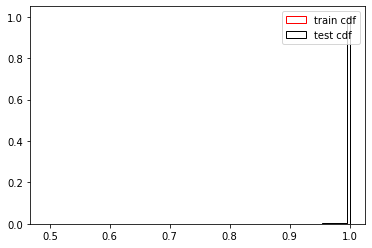

 61%|██████▏   | 289994/473047 [11:16:58<5:28:57,  9.27it/s] 

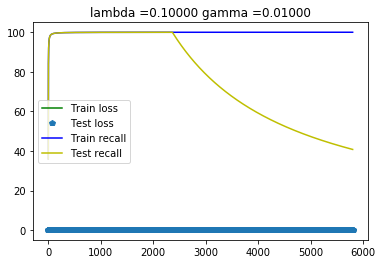

Train cdfs:  0.49988786327933876
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999981  0.99999833]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


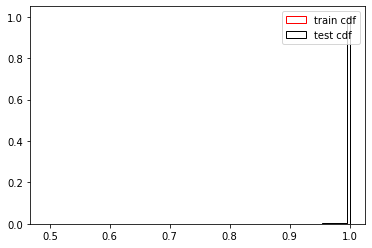

 63%|██████▎   | 299990/473047 [11:38:27<5:02:03,  9.55it/s] 

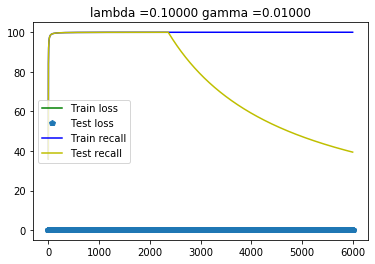

Train cdfs:  0.4998889480252189
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999982  0.99999833]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


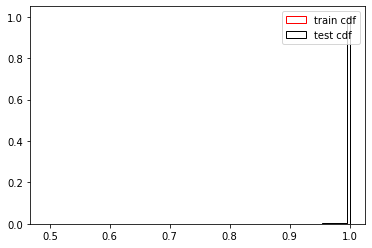

 66%|██████▌   | 309981/473047 [12:03:46<4:15:51, 10.62it/s] 

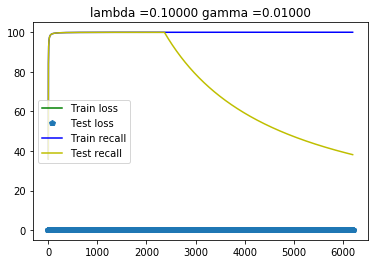

Train cdfs:  0.4998900125066479
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999982  0.99999845]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


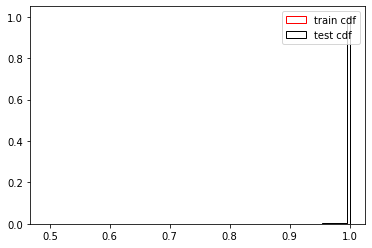

 68%|██████▊   | 319998/473047 [12:29:46<4:11:26, 10.14it/s] 

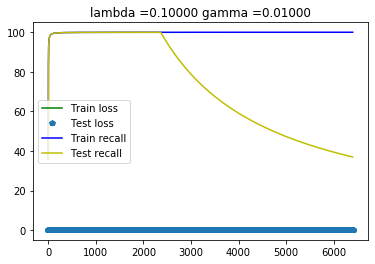

Train cdfs:  0.4998910572667532
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999833 0.9999987 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


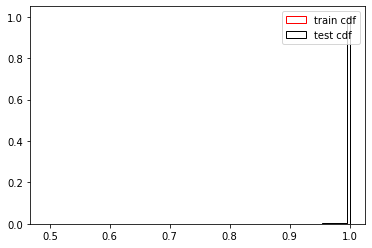

 70%|██████▉   | 329985/473047 [12:51:10<5:10:48,  7.67it/s]

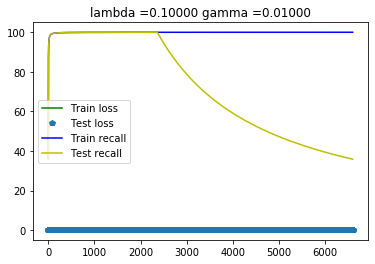

Train cdfs:  0.49989208283040776
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999987  0.99999857]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


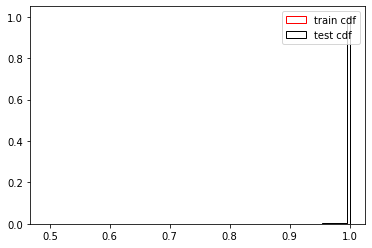

 72%|███████▏  | 339998/473047 [13:12:31<3:36:10, 10.26it/s]

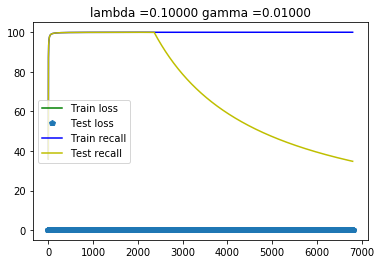

Train cdfs:  0.49989308970492735
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999988 0.9999982]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


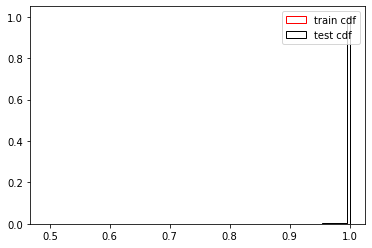

 74%|███████▍  | 349993/473047 [13:33:51<3:38:50,  9.37it/s]

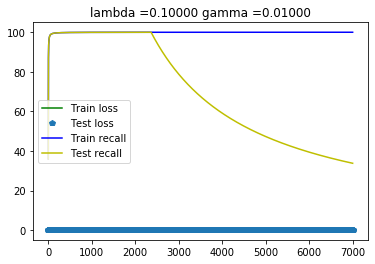

Train cdfs:  0.49989407838074074
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999987 0.9999988]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


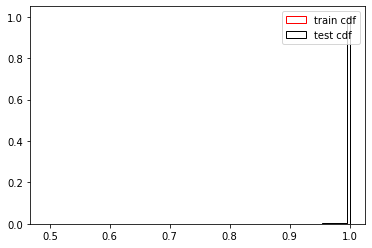

 76%|███████▌  | 359981/473047 [13:54:57<3:57:59,  7.92it/s]

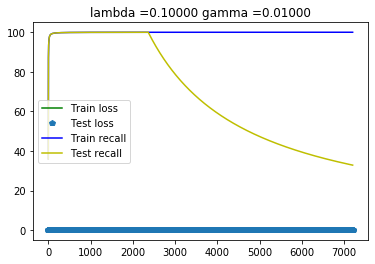

Train cdfs:  0.4998950493320343
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999987  0.99999857]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


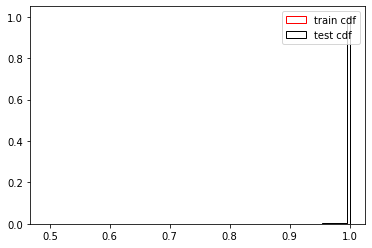

 78%|███████▊  | 369997/473047 [14:25:23<2:43:07, 10.53it/s] 

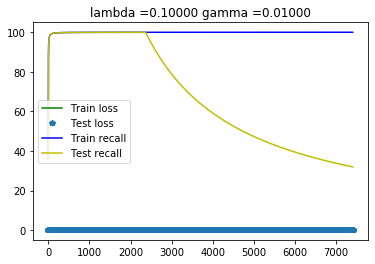

Train cdfs:  0.4998960030173715
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999989  0.99999845]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


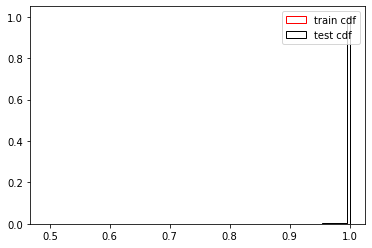

 80%|████████  | 379994/473047 [14:46:36<2:24:16, 10.75it/s]

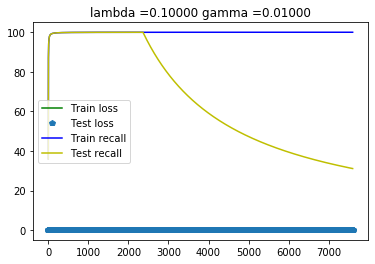

Train cdfs:  0.49989693988028755
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999905 0.99999917]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


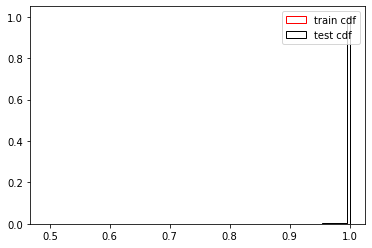

 82%|████████▏ | 389986/473047 [15:07:48<2:58:59,  7.73it/s]

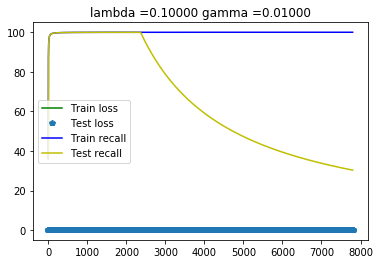

Train cdfs:  0.49989786034986067
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999857 0.99999905]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


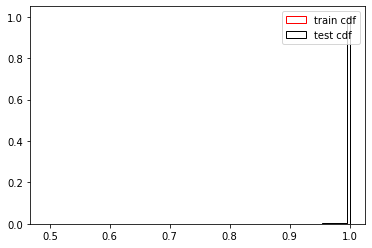

 85%|████████▍ | 399998/473047 [15:29:07<1:51:12, 10.95it/s]

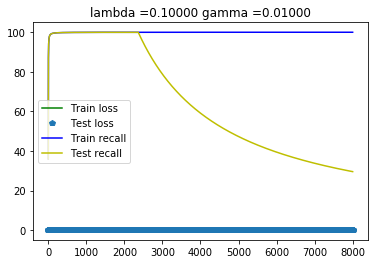

Train cdfs:  0.4998987648412603
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999905 0.99999857]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


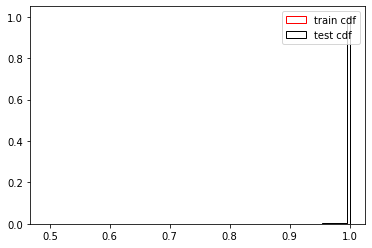

 87%|████████▋ | 409995/473047 [15:51:01<1:39:01, 10.61it/s]

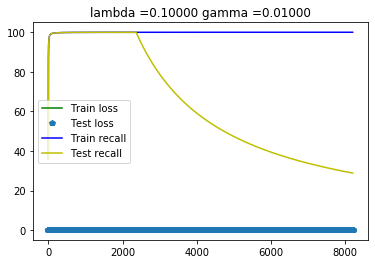

Train cdfs:  0.49989965375627327
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999917 0.9999988 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


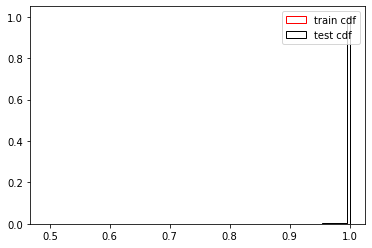

 89%|████████▉ | 419995/473047 [16:21:10<1:30:04,  9.82it/s] 

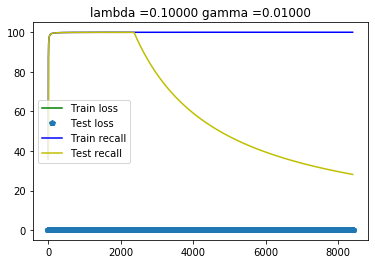

Train cdfs:  0.49990052748380864
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999917 0.9999988 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


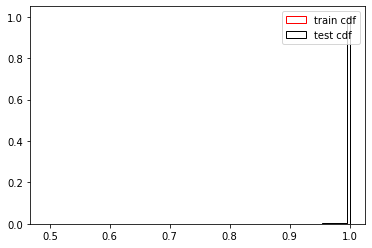

 91%|█████████ | 429980/473047 [16:42:21<1:41:44,  7.05it/s]

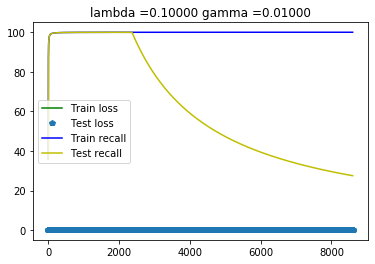

Train cdfs:  0.49990138640038195
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999988 0.9999989]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


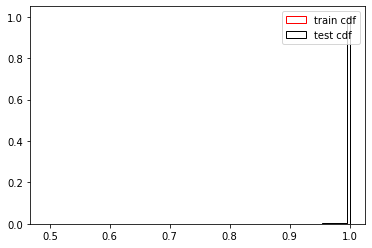

 93%|█████████▎| 439993/473047 [17:03:33<50:48, 10.84it/s]  

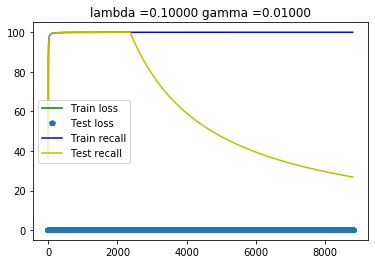

Train cdfs:  0.4999022308705798
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999989 0.9999989]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


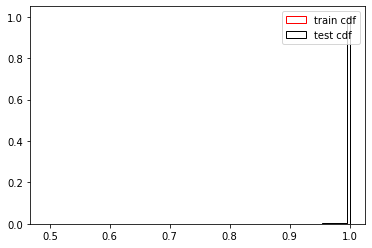

 95%|█████████▌| 449992/473047 [17:24:40<36:03, 10.66it/s]  

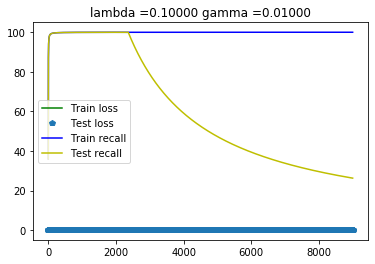

Train cdfs:  0.49990306124750533
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999989 0.9999988]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


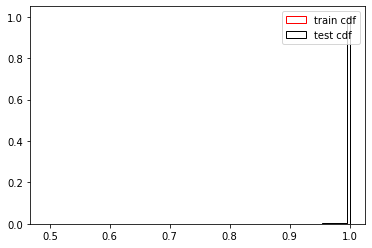

 97%|█████████▋| 460000/473047 [17:45:45<22:34,  9.63it/s]  

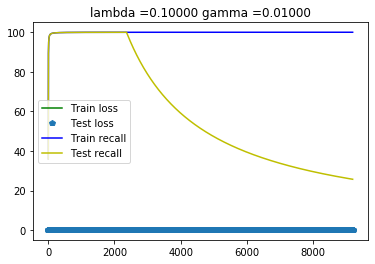

Train cdfs:  0.4999039076021761
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999917 0.99999917]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


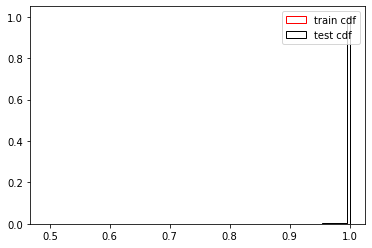

 99%|█████████▉| 470000/473047 [18:14:32<07:23,  6.87it/s]  

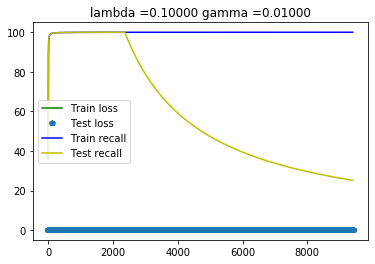

Train cdfs:  0.4999047105278913
Test cdfs:  0.49986490002854245
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999993 0.9999988]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999958 0.9999956]


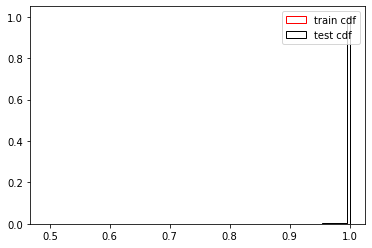

  2%|▏         | 9997/473047 [24:14<4:37:54, 27.77it/s] 

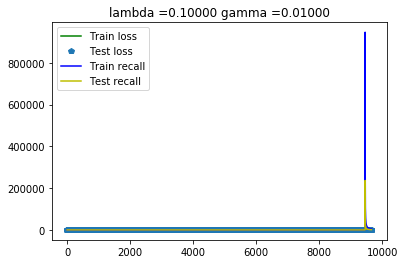

Train cdfs:  0.49991436185211546
Test cdfs:  0.49988317257626597
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999905 0.9999989 ]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999917 0.99999905]


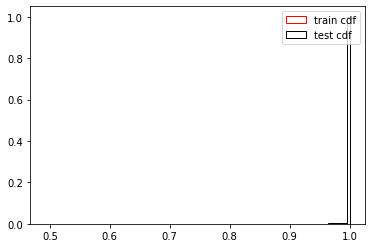

  4%|▍         | 19998/473047 [48:17<4:33:43, 27.59it/s] 

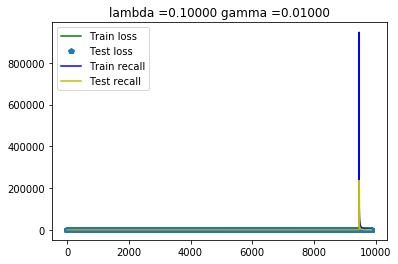

Train cdfs:  0.49992211336830483
Test cdfs:  0.4998971610663405
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999905 0.99999905]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999989  0.99999905]


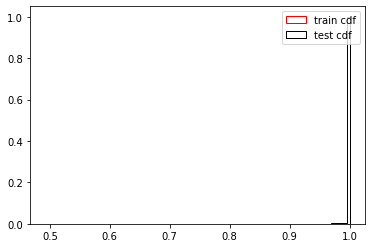

  6%|▋         | 29997/473047 [1:12:39<4:25:40, 27.79it/s] 

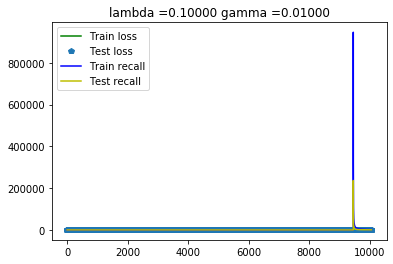

Train cdfs:  0.4999285812020577
Test cdfs:  0.4999081044028865
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.99999917 0.99999905]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.99999905 0.9999993 ]


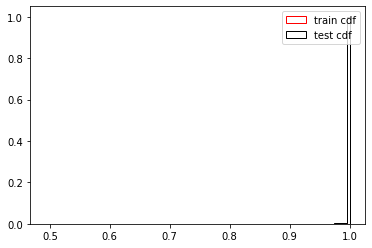

  8%|▊         | 39996/473047 [1:38:23<6:38:06, 18.13it/s]  

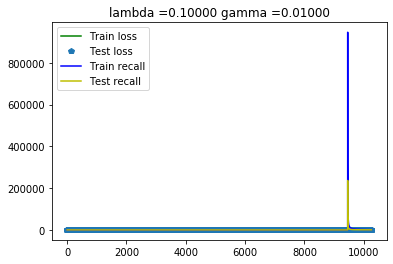

Train cdfs:  0.4999339345981126
Test cdfs:  0.4999168559605787
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999989  0.99999917]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999989 0.9999989]


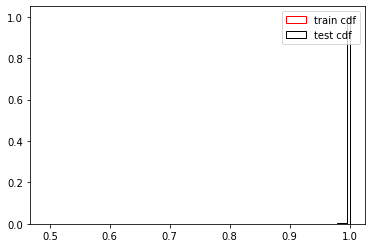

 11%|█         | 49999/473047 [2:29:42<12:11:48,  9.63it/s]  

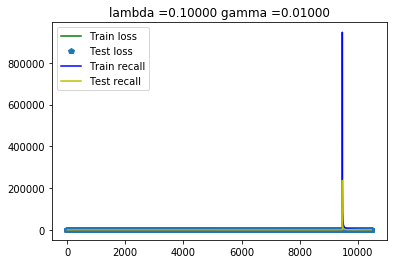

Train cdfs:  0.49993878023296856
Test cdfs:  0.4999243481341903
Train scores unkown:  [0.5023986 0.4973958]
Train scores train:  [0.9999993  0.99999905]
Test scores unkown:  [0.5023986 0.4973958]
Test scores train:  [0.9999993  0.99999905]


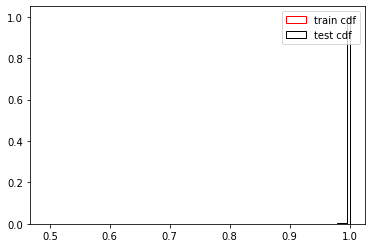

 11%|█▏        | 53400/473047 [3:03:42<12:04:28,  9.65it/s] 

In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 
        train_cdfs = []
        
        test_losses = []
        test_recalls = []
        test_recall_outputs = []
        test_cdfs = []
        
        eval_unknown_outputs = []
        
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        
        sgd(t=50, gamma=gammas[g], lamb=lambdas[l])
        
        j += 1